In [29]:
# Импорты
import numpy as np
import random
import json
import copy
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
from collections import defaultdict


In [30]:
# ОТЛАДОЧНЫЕ НАСТРОЙКИ
SAVE_FIGURES = False

In [31]:
# ПОЛЬЗОВАТЕЛЬСКИЕ НАСТРОЙКИ

# Параметры работы
WORK_START_HOUR = 6
WORK_END_HOUR = 23
WORK_HOURS = WORK_END_HOUR - WORK_START_HOUR

# Кассы
NUM_SIMPLE_REGISTERS = 4  # Простые кассы (требуют кассира)
NUM_AUTO_REGISTERS = 3    # Автоматические кассы (терминалы)
AUTO_SERVICE_TIME = 150   # Время обслуживания в автоматической кассе (сек)

# Кассиры
CASHIERS = [
    {'id': 0, 'simple_time': 120, 'auto_time': 75},
    {'id': 1, 'simple_time': 140, 'auto_time': 70},
    {'id': 2, 'simple_time': 130, 'auto_time': 65},
    {'id': 3, 'simple_time': 150, 'auto_time': 60},
    {'id': 4, 'simple_time': 110, 'auto_time': 80},
    {'id': 5, 'simple_time': 135, 'auto_time': 72},
    {'id': 6, 'simple_time': 145, 'auto_time': 62},
    {'id': 7, 'simple_time': 145, 'auto_time': 62}
]

CASHIER_MIN_WORK_HOURS = 7  # Минимальная продолжительность работы кассира (часов)
CASHIER_MAX_WORK_HOURS = 8  # Максимальная продолжительность работы кассира (часов)


ACCEPTABLE_WAIT_TIME = 15   # Желаемое среднее время ожидания
MIN_WAIT_TIME = 5           # Желаемое минимальное время ожидания

# Параметры генетического алгоритма
POPULATION_SIZE = 100
ELITE_SIZE = 20
MAX_GENERATIONS = 400
MAX_GENERATION_WITHOUT_IMPROVEMENT = 50
MUTATION_RATE = 0.2
CROSSOVER_RATE = 0.7
TOURNAMENT_SIZE = 10

NUM_CASHIERS_PENALTY_MULTIPLYER = 10      # Мультпликатор штрафа за количество кассиров (минимизация числа кассиров)
WAIT_PENALTY_MULTIPLYER = 10              # Мультпликатор штрафа за превышение допустимого времени ожидания (ACCEPTABLE_WAIT_TIME)
WAIT_OPTIMIZATION_PENALTY_MULTIPLYER = 2  # Мультпликатор штрафа за отклонение от целевого минимального времени ожидания (MIN_WAIT_TIME)
CAPACITY_PENALTY_MULTIPLYER = 1           # Мультпликатор штрафа за дефицит пропускной способности в часы пиковой нагрузки
UNIFORMITY_PENALTY_MULTIPLYER = 1         # Мультпликатор штрафа за неравномерность превышения пропускной способности по часам


In [32]:
# Параметры гауссовых пиков (задают пользователь)
peak1_hour = 11   # час-пик 1
peak2_hour = 18   # час-пик 2

base_clients = 50     # Минимальное количество клиентов в "спокойные" часы
peak1_strength = 30  # Максимальное значение первого пика
peak2_strength = 15  # Максимальное значение второго пика
peak1_width = 2     # Ширина первого пика
peak2_width = 2       # Ширина второго пика

In [33]:
if peak1_hour > WORK_START_HOUR:
    peak1_hour -= WORK_START_HOUR
if peak2_hour > WORK_START_HOUR:
    peak2_hour -= WORK_START_HOUR

# Поток клиентов по часам (среднее количество клиентов в час)
hours = np.arange(WORK_HOURS)
CLIENT_FLOW = (
    base_clients +
    peak1_strength * np.exp(-((hours - peak1_hour)**2) / (2 * peak1_width**2)) +
    peak2_strength * np.exp(-((hours - peak2_hour)**2) / (2 * peak2_width**2))
)
CLIENT_FLOW = np.round(CLIENT_FLOW).astype(int).tolist()

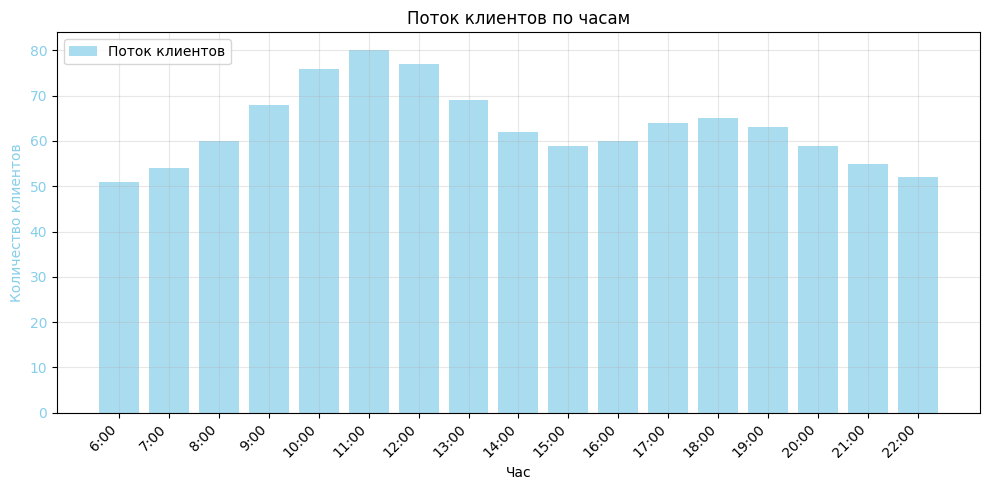

In [34]:
hours_labels = [f"{WORK_START_HOUR + h}:00" for h in range(WORK_HOURS)]

plt.figure(figsize=(10, 5))
plt.bar(range(len(CLIENT_FLOW)), CLIENT_FLOW, alpha=0.7, color='skyblue', label='Поток клиентов')
plt.xlabel('Час')
plt.ylabel('Количество клиентов', color='skyblue')
plt.tick_params(axis='y', labelcolor='skyblue')
plt.xticks(range(WORK_HOURS), hours_labels, rotation=45, ha='right')
plt.title('Поток клиентов по часам')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
if SAVE_FIGURES: plt.savefig('client_flow.png', dpi=150, bbox_inches='tight')
plt.show()

In [35]:
# Функции для расчета пропускной способности и времени ожидания

def calculate_throughput(schedule: Dict) -> List[float]:
    """
    Рассчитывает пропускную способность (клиентов в час) для каждого часа.
    Пропускная способность = 3600 / среднее_время_обслуживания
    """
    throughput = []
    
    for hour in range(WORK_HOURS):
        total_capacity = 0
        
        for reg_id in range(NUM_SIMPLE_REGISTERS):
            cashier_id = schedule['simple'][reg_id][hour]
            if cashier_id is not None:
                service_time = CASHIERS[cashier_id]['simple_time']
                total_capacity += 3600 / service_time
        
        for reg_id in range(NUM_AUTO_REGISTERS):
            cashier_id = schedule['auto'][reg_id][hour]
            if cashier_id is not None:
                service_time = CASHIERS[cashier_id]['auto_time']
                total_capacity += 3600 / service_time
            else:
                total_capacity += 3600 / AUTO_SERVICE_TIME
        
        throughput.append(total_capacity)
    
    return throughput


def calculate_wait_time(schedule: Dict) -> float:
    """
    Упрощенная модель расчета среднего времени ожидания.
    Использует формулу M/M/c для оценки времени ожидания в очереди.
    """
    throughput = calculate_throughput(schedule)
    total_wait = 0
    total_clients = sum(CLIENT_FLOW)
    
    for hour in range(WORK_HOURS):
        arrival_rate = CLIENT_FLOW[hour]
        capacity = throughput[hour]
        
        if capacity == 0:
            wait = 120
        elif arrival_rate >= capacity:
            wait = 60 + (arrival_rate - capacity) * 2
        else:
            utilization = arrival_rate / capacity
            if utilization < 0.95:
                avg_service_time = 3600 / capacity if capacity > 0 else 0
                wait = (avg_service_time / 60) / (1 - utilization) if utilization < 1 else 60
            else:
                wait = 30
        
        total_wait += wait * arrival_rate
    
    return total_wait / total_clients if total_clients > 0 else 0


def count_active_cashiers(schedule: Dict) -> int:
    """
    Подсчитывает количество кассиров, задействованных в расписании.
    """
    active = set()
    
    for reg_id in range(NUM_SIMPLE_REGISTERS):
        for hour in range(WORK_HOURS):
            cashier_id = schedule['simple'][reg_id][hour]
            if cashier_id is not None:
                active.add(cashier_id)
    
    for reg_id in range(NUM_AUTO_REGISTERS):
        for hour in range(WORK_HOURS):
            cashier_id = schedule['auto'][reg_id][hour]
            if cashier_id is not None:
                active.add(cashier_id)
    
    return len(active)


def validate_schedule(schedule: Dict) -> bool:
    """
    Проверяет корректность расписания:
    - Кассир работает непрерывно от MIN до MAX часов
    - Кассир не может работать на двух кассах одновременно
    """
    cashier_hours = defaultdict(list)
    
    for reg_id in range(NUM_SIMPLE_REGISTERS):
        for hour in range(WORK_HOURS):
            cashier_id = schedule['simple'][reg_id][hour]
            if cashier_id is not None:
                cashier_hours[cashier_id].append(hour)
    
    for reg_id in range(NUM_AUTO_REGISTERS):
        for hour in range(WORK_HOURS):
            cashier_id = schedule['auto'][reg_id][hour]
            if cashier_id is not None:
                cashier_hours[cashier_id].append(hour)
    
    for cashier_id, hours in cashier_hours.items():
        hours = sorted(set(hours))
        
        if len(hours) > 0:
            expected = list(range(hours[0], hours[-1] + 1))
            if hours != expected:
                return False
            
            work_hours = len(hours)
            if work_hours < CASHIER_MIN_WORK_HOURS or work_hours > CASHIER_MAX_WORK_HOURS:
                return False
    
    for hour in range(WORK_HOURS):
        hour_cashiers = []
        
        for reg_id in range(NUM_SIMPLE_REGISTERS):
            cashier_id = schedule['simple'][reg_id][hour]
            if cashier_id is not None:
                hour_cashiers.append(cashier_id)
        
        for reg_id in range(NUM_AUTO_REGISTERS):
            cashier_id = schedule['auto'][reg_id][hour]
            if cashier_id is not None:
                hour_cashiers.append(cashier_id)
        
        if len(hour_cashiers) != len(set(hour_cashiers)):
            return False
    
    return True


In [36]:
# Генетический алгоритм - Часть 1: Создание расписаний

def create_empty_schedule() -> Dict:
    """
    Создает пустое расписание.
    """
    return {
        'simple': [[None for _ in range(WORK_HOURS)] for _ in range(NUM_SIMPLE_REGISTERS)],
        'auto': [[None for _ in range(WORK_HOURS)] for _ in range(NUM_AUTO_REGISTERS)]
    }


def create_random_schedule() -> Dict:
    """
    Создает случайное валидное расписание.
    """
    schedule = create_empty_schedule()
    
    num_cashiers = random.randint(1, len(CASHIERS))
    selected_cashiers = random.sample(range(len(CASHIERS)), num_cashiers)
    
    for cashier_id in selected_cashiers:
        work_duration = random.randint(CASHIER_MIN_WORK_HOURS, CASHIER_MAX_WORK_HOURS)
        latest_start = WORK_HOURS - work_duration
        start_hour = random.randint(0, latest_start)
        register_type = random.choice(['simple', 'auto'])
        
        if register_type == 'simple':
            registers = schedule['simple']
            num_regs = NUM_SIMPLE_REGISTERS
        else:
            registers = schedule['auto']
            num_regs = NUM_AUTO_REGISTERS
        
        for reg_id in range(num_regs):
            can_place = True
            for h in range(start_hour, start_hour + work_duration):
                if registers[reg_id][h] is not None:
                    can_place = False
                    break
            
            if can_place:
                for h in range(start_hour, start_hour + work_duration):
                    registers[reg_id][h] = cashier_id
                break
    
    return schedule


def fitness(schedule: Dict) -> float:
    """
    Функция приспособленности.
    Минимизируем: штраф за превышение времени ожидания + количество кассиров + дефицит пропускной способности.
    Оптимизируем до MIN_WAIT_TIME с равномерным превышением пропускной способности.
    """
    if not validate_schedule(schedule):
        return float('inf')  # Невалидное расписание
    
    wait_time = calculate_wait_time(schedule)
    num_cashiers = count_active_cashiers(schedule)
    throughput = calculate_throughput(schedule)
    
    # Штраф за превышение допустимого времени ожидания
    wait_penalty = max(0, wait_time - ACCEPTABLE_WAIT_TIME)
    
    # Продолжаем оптимизировать время ожидания до MIN_WAIT_TIME
    if wait_time > MIN_WAIT_TIME:
        # Плавный штраф, который уменьшается по мере приближения к MIN_WAIT_TIME
        wait_optimization = (wait_time - MIN_WAIT_TIME)
    else:
        wait_optimization = 0
    
    # Штраф за дефицит пропускной способности в каждый час
    capacity_penalty = 0
    for hour in range(WORK_HOURS):
        deficit = CLIENT_FLOW[hour] - throughput[hour]
        if deficit > 0:
            # Базовый штраф за дефицит
            hourly_penalty = deficit * 0.5
            
            # Увеличенный штраф для последних 3 часов (критически важные часы)
            if hour >= WORK_HOURS - 3:
                hourly_penalty *= 3.0  # Тройной штраф для последних часов
            
            # Увеличенный штраф для пиковых часов (где поток > 120)
            if CLIENT_FLOW[hour] > 120:
                hourly_penalty *= 1.5
            
            capacity_penalty += hourly_penalty
    
    # Вычисляем процент превышения для каждого часа
    surpluses = []
    for hour in range(WORK_HOURS):
        if throughput[hour] > CLIENT_FLOW[hour]:
            surplus_percent = (throughput[hour] - CLIENT_FLOW[hour]) / CLIENT_FLOW[hour] * 100
            surpluses.append(surplus_percent)
    
    # Штраф за неравномерность
    uniformity_penalty = 0
    if len(surpluses) > 1:
        mean_surplus = np.mean(surpluses)
        std_surplus = np.std(surpluses)
        uniformity_penalty = std_surplus * 0.3
        if mean_surplus < 10:
            uniformity_penalty += (10 - mean_surplus) * 0.5
    elif len(surpluses) == 0:
        uniformity_penalty = 50
    
    # Общий фитнес: минимизируем количество кассиров + штрафы
    return  num_cashiers * NUM_CASHIERS_PENALTY_MULTIPLYER +\
            wait_penalty * WAIT_PENALTY_MULTIPLYER +\
            wait_optimization * WAIT_OPTIMIZATION_PENALTY_MULTIPLYER +\
            capacity_penalty * CAPACITY_PENALTY_MULTIPLYER +\
            uniformity_penalty * UNIFORMITY_PENALTY_MULTIPLYER


def tournament_selection(population: List[Dict], fitnesses: List[float]) -> Dict:
    """
    Турнирная селекция.
    """
    tournament = random.sample(list(zip(population, fitnesses)), TOURNAMENT_SIZE)
    winner = min(tournament, key=lambda x: x[1])
    return copy.deepcopy(winner[0])


In [37]:
# Генетический алгоритм - Часть 2: Операторы скрещивания и мутации

def crossover(parent1: Dict, parent2: Dict) -> Tuple[Dict, Dict]:
    """
    Одноточечное скрещивание по часам.
    """
    if random.random() > CROSSOVER_RATE:
        return copy.deepcopy(parent1), copy.deepcopy(parent2)
    
    child1 = create_empty_schedule()
    child2 = create_empty_schedule()
    
    crossover_point = random.randint(1, WORK_HOURS - 1)
    
    # Копируем первую часть от parent1, вторую от parent2
    for reg_id in range(NUM_SIMPLE_REGISTERS):
        child1['simple'][reg_id] = (parent1['simple'][reg_id][:crossover_point] + 
                                     parent2['simple'][reg_id][crossover_point:])
        child2['simple'][reg_id] = (parent2['simple'][reg_id][:crossover_point] + 
                                     parent1['simple'][reg_id][crossover_point:])
    
    for reg_id in range(NUM_AUTO_REGISTERS):
        child1['auto'][reg_id] = (parent1['auto'][reg_id][:crossover_point] + 
                                   parent2['auto'][reg_id][crossover_point:])
        child2['auto'][reg_id] = (parent2['auto'][reg_id][:crossover_point] + 
                                   parent1['auto'][reg_id][crossover_point:])
    
    return child1, child2


def mutate(schedule: Dict) -> Dict:
    """
    Мутация: случайное изменение расписания одного кассира.
    Включает умную мутацию для покрытия дефицитных часов.
    """
    if random.random() > MUTATION_RATE:
        return schedule
    
    schedule = copy.deepcopy(schedule)
    mutation_type = random.choice(['add', 'remove', 'shift', 'swap', 'cover_deficit'])
    
    if mutation_type == 'add':
        cashier_id = random.randint(0, len(CASHIERS) - 1)
        work_duration = random.randint(CASHIER_MIN_WORK_HOURS, CASHIER_MAX_WORK_HOURS)
        start_hour = random.randint(0, WORK_HOURS - work_duration)
        register_type = random.choice(['simple', 'auto'])
        
        registers = schedule[register_type]
        num_regs = NUM_SIMPLE_REGISTERS if register_type == 'simple' else NUM_AUTO_REGISTERS
        
        for reg_id in range(num_regs):
            can_place = all(registers[reg_id][h] is None 
                          for h in range(start_hour, start_hour + work_duration))
            if can_place:
                for h in range(start_hour, start_hour + work_duration):
                    registers[reg_id][h] = cashier_id
                break
    
    elif mutation_type == 'remove':
        active = set()
        for regs in [schedule['simple'], schedule['auto']]:
            for reg in regs:
                active.update(c for c in reg if c is not None)
        
        if active:
            cashier_to_remove = random.choice(list(active))
            for regs in [schedule['simple'], schedule['auto']]:
                for reg in regs:
                    for h in range(len(reg)):
                        if reg[h] == cashier_to_remove:
                            reg[h] = None
    
    elif mutation_type == 'shift':
        register_type = random.choice(['simple', 'auto'])
        registers = schedule[register_type]
        num_regs = NUM_SIMPLE_REGISTERS if register_type == 'simple' else NUM_AUTO_REGISTERS
        reg_id = random.randint(0, num_regs - 1)
        
        cashiers_in_reg = [c for c in registers[reg_id] if c is not None]
        if cashiers_in_reg:
            cashier_id = cashiers_in_reg[0]
            for h in range(WORK_HOURS):
                if registers[reg_id][h] == cashier_id:
                    registers[reg_id][h] = None
            
            work_duration = random.randint(CASHIER_MIN_WORK_HOURS, CASHIER_MAX_WORK_HOURS)
            start_hour = random.randint(0, WORK_HOURS - work_duration)
            can_place = all(registers[reg_id][h] is None 
                          for h in range(start_hour, min(start_hour + work_duration, WORK_HOURS)))
            if can_place:
                for h in range(start_hour, min(start_hour + work_duration, WORK_HOURS)):
                    registers[reg_id][h] = cashier_id
    
    elif mutation_type == 'swap':
        if random.random() < 0.5 and NUM_SIMPLE_REGISTERS > 0 and NUM_AUTO_REGISTERS > 0:
            source = schedule['simple']
            target = schedule['auto']
            num_target = NUM_AUTO_REGISTERS
        elif NUM_SIMPLE_REGISTERS > 0 and NUM_AUTO_REGISTERS > 0:
            source = schedule['auto']
            target = schedule['simple']
            num_target = NUM_SIMPLE_REGISTERS
        else:
            return schedule
        
        for src_reg_id, reg in enumerate(source):
            cashiers_in_reg = [c for c in reg if c is not None]
            if cashiers_in_reg:
                cashier_id = cashiers_in_reg[0]
                work_hours_indices = [h for h in range(WORK_HOURS) if reg[h] == cashier_id]
                if work_hours_indices:
                    start = min(work_hours_indices)
                    end = max(work_hours_indices) + 1
                    
                    for tgt_reg_id in range(num_target):
                        can_place = all(target[tgt_reg_id][h] is None for h in range(start, end))
                        if can_place:
                            for h in range(start, end):
                                source[src_reg_id][h] = None
                            for h in range(start, end):
                                target[tgt_reg_id][h] = cashier_id
                            break
                break
    
    elif mutation_type == 'cover_deficit':
        # Целенаправленное покрытие дефицитных часов
        throughput = calculate_throughput(schedule)
        
        # Находим часы с наибольшим дефицитом
        deficits = []
        for hour in range(WORK_HOURS):
            deficit = CLIENT_FLOW[hour] - throughput[hour]
            if deficit > 0:
                deficits.append((deficit, hour))
        
        if deficits:
            deficits.sort(reverse=True)
            target_hour = deficits[0][1]
            
            cashier_id = random.randint(0, len(CASHIERS) - 1)
            work_duration = random.randint(CASHIER_MIN_WORK_HOURS, CASHIER_MAX_WORK_HOURS)
            
            offset = random.randint(0, work_duration - 1)
            start_hour = max(0, min(target_hour - offset, WORK_HOURS - work_duration))
            
            if target_hour >= WORK_HOURS - 3:
                register_type = 'auto' if random.random() < 0.7 else 'simple'
            else:
                register_type = random.choice(['simple', 'auto'])
            
            registers = schedule[register_type]
            num_regs = NUM_SIMPLE_REGISTERS if register_type == 'simple' else NUM_AUTO_REGISTERS
            
            for reg_id in range(num_regs):
                can_place = all(registers[reg_id][h] is None 
                              for h in range(start_hour, start_hour + work_duration))
                if can_place:
                    for h in range(start_hour, start_hour + work_duration):
                        registers[reg_id][h] = cashier_id
                    break
    
    return schedule


In [38]:
# Генетический алгоритм - Часть 3: Основной цикл

def genetic_algorithm():
    """
    Основной цикл генетического алгоритма.
    """
    print("Запуск генетического алгоритма...\n")
    print("Инициализация популяции...")
    
    # Инициализация популяции
    population = [create_random_schedule() for _ in range(POPULATION_SIZE)]
    
    best_schedule = None
    best_fitness = float('inf')
    generations_without_improvement = 0
    
    for generation in range(MAX_GENERATIONS):
        # Оценка популяции
        fitnesses = [fitness(ind) for ind in population]
        
        # Обновление лучшего решения
        min_fitness_idx = np.argmin(fitnesses)
        if fitnesses[min_fitness_idx] < best_fitness:
            best_fitness = fitnesses[min_fitness_idx]
            best_schedule = copy.deepcopy(population[min_fitness_idx])
            generations_without_improvement = 0
            
            print(f"Поколение {generation + 1}: Fitness={best_fitness:.2f}")
        else:
            generations_without_improvement += 1
        
        # Критерий остановки
        if generations_without_improvement > MAX_GENERATION_WITHOUT_IMPROVEMENT:
            print(f"\nСходимость достигнута на поколении {generation + 1}")
            break
        
        # Создание новой популяции
        new_population = []
        
        # Элитизм: сохраняем лучшие 10%
        elite_indices = np.argsort(fitnesses)[:ELITE_SIZE]
        new_population.extend([copy.deepcopy(population[i]) for i in elite_indices])
        
        # Создание потомков
        while len(new_population) < POPULATION_SIZE:
            parent1 = tournament_selection(population, fitnesses)
            parent2 = tournament_selection(population, fitnesses)
            
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1)
            child2 = mutate(child2)
            
            new_population.append(child1)
            if len(new_population) < POPULATION_SIZE:
                new_population.append(child2)
        
        population = new_population
    
    return best_schedule


In [39]:
# Запуск оптимизации
best_schedule = genetic_algorithm()

# Вывод результатов
print("\n" + "="*26)
print("ИСКОМОЕ РАСПИСАНИЕ НАЙДЕНО")
print("="*26)

num_cashiers = count_active_cashiers(best_schedule)
wait_time = calculate_wait_time(best_schedule)

print(f"\nКоличество кассиров: {num_cashiers}")
print(f"Среднее время ожидания: {wait_time:.2f} минут")
print(f"Допустимое время: {ACCEPTABLE_WAIT_TIME} минут")
print(f"Целевое минимальное время: {MIN_WAIT_TIME} минут")

# Показываем, достигнута ли цель
if wait_time <= MIN_WAIT_TIME:
    print(f"✓ Целевое минимальное время ожидания ДОСТИГНУТО!")
elif wait_time <= ACCEPTABLE_WAIT_TIME:
    print(f"✓ Время ожидания в пределах допустимого (можно продолжить оптимизацию)")
else:
    print(f"✗ Время ожидания превышает допустимое")

# Детальный вывод расписания
print("\nДетали расписания:")

# Собираем информацию о каждом кассире
cashier_info = defaultdict(lambda: {'hours': [], 'register_type': None, 'register_id': None})

for reg_id in range(NUM_SIMPLE_REGISTERS):
    for hour in range(WORK_HOURS):
        cashier_id = best_schedule['simple'][reg_id][hour]
        if cashier_id is not None:
            if not cashier_info[cashier_id]['hours']:
                cashier_info[cashier_id]['register_type'] = 'Простая'
                cashier_info[cashier_id]['register_id'] = reg_id
            cashier_info[cashier_id]['hours'].append(hour)

for reg_id in range(NUM_AUTO_REGISTERS):
    for hour in range(WORK_HOURS):
        cashier_id = best_schedule['auto'][reg_id][hour]
        if cashier_id is not None:
            if not cashier_info[cashier_id]['hours']:
                cashier_info[cashier_id]['register_type'] = 'Автомат'
                cashier_info[cashier_id]['register_id'] = reg_id
            cashier_info[cashier_id]['hours'].append(hour)

for cashier_id in sorted(cashier_info.keys()):
    info = cashier_info[cashier_id]
    hours = sorted(set(info['hours']))
    if hours:
        start_time = f"{WORK_START_HOUR + hours[0]:02d}:00"
        end_time = f"{WORK_START_HOUR + hours[-1] + 1:02d}:00"
        print(f"  Кассир {cashier_id}: {start_time} - {end_time} "
              f"({info['register_type']} касса {info['register_id']})")


Запуск генетического алгоритма...

Инициализация популяции...
Поколение 1: Fitness=13.81

Сходимость достигнута на поколении 52

ИСКОМОЕ РАСПИСАНИЕ НАЙДЕНО

Количество кассиров: 1
Среднее время ожидания: 4.16 минут
Допустимое время: 15 минут
Целевое минимальное время: 5 минут
✓ Целевое минимальное время ожидания ДОСТИГНУТО!

Детали расписания:
  Кассир 4: 08:00 - 15:00 (Автомат касса 0)


In [40]:
# Анализ пропускной способности
throughput = calculate_throughput(best_schedule)

print("\n" + "="*29)
print("АНАЛИЗ ПРОПУСКНОЙ СПОСОБНОСТИ")
print("="*29)

# Рассчитываем метрики равномерности
surpluses_percent = []
for hour in range(WORK_HOURS):
    if throughput[hour] > CLIENT_FLOW[hour]:
        surplus_percent = (throughput[hour] - CLIENT_FLOW[hour]) / CLIENT_FLOW[hour] * 100
        surpluses_percent.append(surplus_percent)

if surpluses_percent:
    mean_surplus = np.mean(surpluses_percent)
    std_surplus = np.std(surpluses_percent)
    min_surplus = np.min(surpluses_percent)
    max_surplus = np.max(surpluses_percent)
    
    print(f"\nМетрики равномерности превышения пропускной способности:")
    print(f"  Среднее превышение: {mean_surplus:.1f}%")
    print(f"  Стандартное отклонение: {std_surplus:.1f}%")
    print(f"  Диапазон: {min_surplus:.1f}% - {max_surplus:.1f}%")
    print(f"  Часов с превышением: {len(surpluses_percent)}/{WORK_HOURS}")

title_line = f"{'Час':<15} | {'Клиенты':<15} | {'Пропускная':<15} | {'Разница':<15} | {'Превышение':<15}"
title_border = "".join(["-" if elem != "|" else "|" for elem in title_line])

print(f"\n{title_line}")
print(f"{title_border}")

for hour in range(WORK_HOURS):
    clients = CLIENT_FLOW[hour]
    capacity = throughput[hour]
    diff = capacity - clients
    status = "(+)" if diff >= 0 else "(-)"
    
    if diff >= 0 and clients > 0:
        surplus_percent = (diff / clients) * 100
        surplus_str = f"{surplus_percent:.1f}%"
    else:
        surplus_str = "-"
    
    start_h = WORK_START_HOUR + hour
    end_h = start_h + 1
    time_str = f"{start_h:02d}:00-{end_h:02d}:00"
    
    print(f"{time_str:<15} | {clients:<15} | {capacity:<15.1f} | {diff:<9.1f} {status:<5} | {surplus_str:<15}")



АНАЛИЗ ПРОПУСКНОЙ СПОСОБНОСТИ

Метрики равномерности превышения пропускной способности:
  Среднее превышение: 28.3%
  Стандартное отклонение: 12.7%
  Диапазон: 10.8% - 55.0%
  Часов с превышением: 17/17

Час             | Клиенты         | Пропускная      | Разница         | Превышение     
----------------|-----------------|-----------------|-----------------|----------------
06:00-07:00     | 51              | 72.0            | 21.0      (+)   | 41.2%          
07:00-08:00     | 54              | 72.0            | 18.0      (+)   | 33.3%          
08:00-09:00     | 60              | 93.0            | 33.0      (+)   | 55.0%          
09:00-10:00     | 68              | 93.0            | 25.0      (+)   | 36.8%          
10:00-11:00     | 76              | 93.0            | 17.0      (+)   | 22.4%          
11:00-12:00     | 80              | 93.0            | 13.0      (+)   | 16.2%          
12:00-13:00     | 77              | 93.0            | 16.0      (+)   | 20.8%          
13:

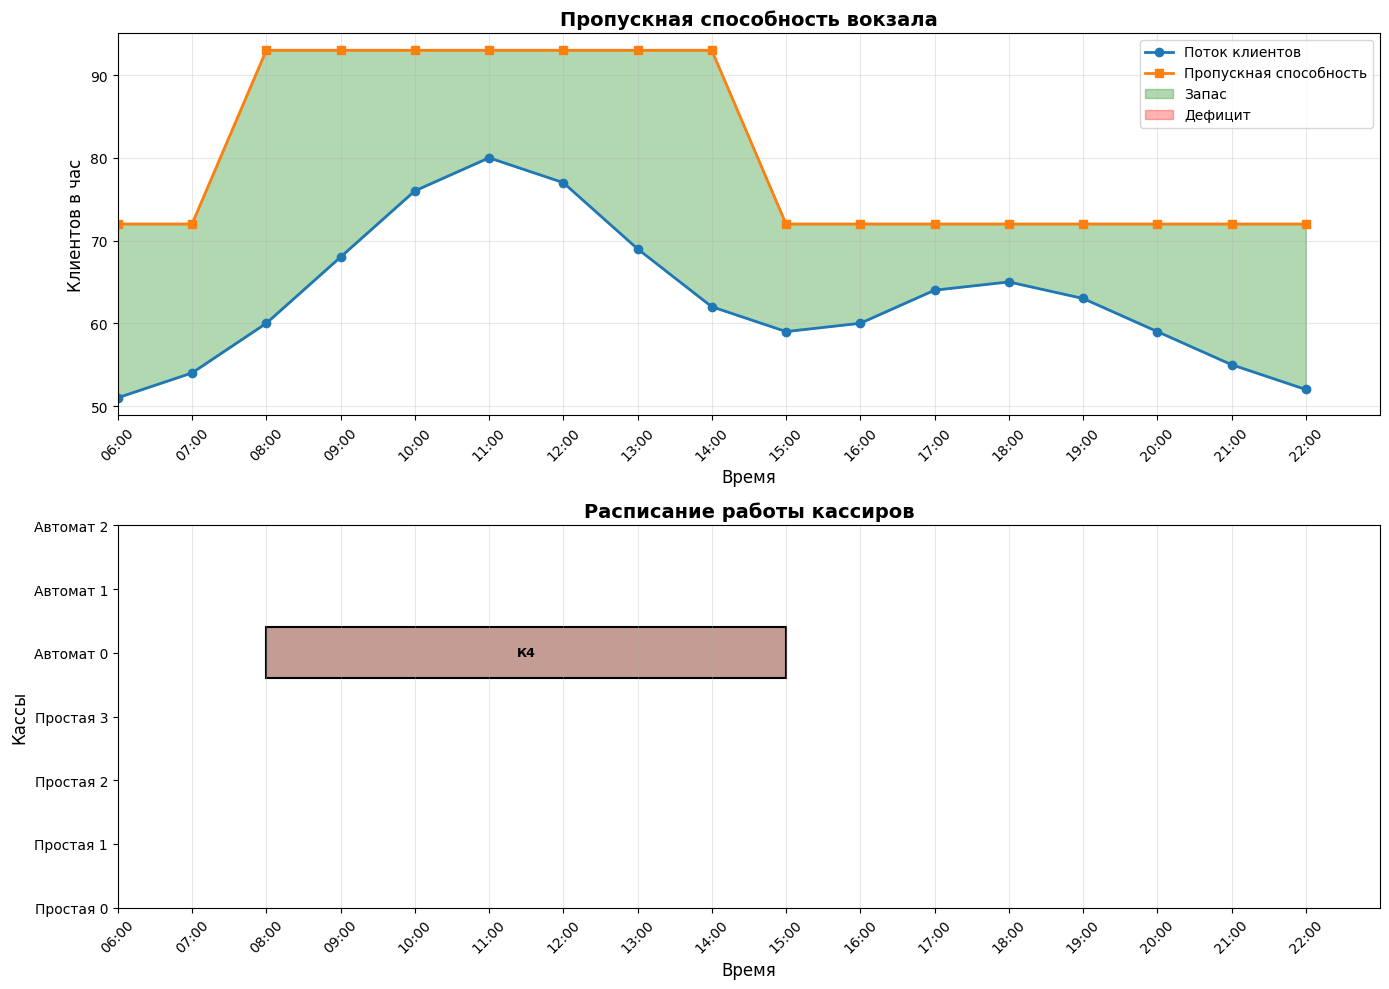


Визуализация сохранена в файл: schedule_visualization.png


In [41]:
# Визуализация расписания - График 1: Пропускная способность

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# График 1: Сравнение потока клиентов и пропускной способности
hours_labels = [f"{WORK_START_HOUR + h:02d}:00" for h in range(WORK_HOURS)]

axes[0].plot(hours_labels, CLIENT_FLOW, marker='o', label='Поток клиентов', linewidth=2)
axes[0].plot(hours_labels, throughput, marker='s', label='Пропускная способность', linewidth=2)
axes[0].fill_between(range(WORK_HOURS), CLIENT_FLOW, throughput, 
                      where=[t >= c for t, c in zip(throughput, CLIENT_FLOW)], 
                      alpha=0.3, color='green', label='Запас')
axes[0].fill_between(range(WORK_HOURS), CLIENT_FLOW, throughput, 
                      where=[t < c for t, c in zip(throughput, CLIENT_FLOW)], 
                      alpha=0.3, color='red', label='Дефицит')
axes[0].set_xlabel('Время', fontsize=12)
axes[0].set_ylabel('Клиентов в час', fontsize=12)
axes[0].set_title('Пропускная способность вокзала', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_xlim(0, WORK_HOURS)

# Визуализация расписания - График 2: Расписание кассиров
colors = plt.cm.tab20(np.linspace(0, 1, len(CASHIERS)))

y_pos = 0
y_labels = []
y_ticks = []

# Простые кассы
for reg_id in range(NUM_SIMPLE_REGISTERS):
    y_labels.append(f"Простая {reg_id}")
    y_ticks.append(y_pos)
    
    current_cashier = None
    start_hour = None
    
    for hour in range(WORK_HOURS + 1):
        if hour < WORK_HOURS:
            cashier_id = best_schedule['simple'][reg_id][hour]
        else:
            cashier_id = None
        
        if cashier_id != current_cashier:
            if current_cashier is not None:
                axes[1].barh(y_pos, hour - start_hour, left=start_hour, height=0.8,
                        color=colors[current_cashier], 
                        edgecolor='black', linewidth=1.5)
                axes[1].text(start_hour + (hour - start_hour) / 2, y_pos, 
                        f'К{current_cashier}', ha='center', va='center', 
                        fontsize=9, fontweight='bold')
            
            current_cashier = cashier_id
            start_hour = hour
    
    y_pos += 1

# Автоматические кассы
for reg_id in range(NUM_AUTO_REGISTERS):
    y_labels.append(f"Автомат {reg_id}")
    y_ticks.append(y_pos)
    
    current_cashier = None
    start_hour = None
    
    for hour in range(WORK_HOURS + 1):
        if hour < WORK_HOURS:
            cashier_id = best_schedule['auto'][reg_id][hour]
        else:
            cashier_id = None
        
        if cashier_id != current_cashier:
            if current_cashier is not None:
                axes[1].barh(y_pos, hour - start_hour, left=start_hour, height=0.8,
                        color=colors[current_cashier], 
                        edgecolor='black', linewidth=1.5)
                axes[1].text(start_hour + (hour - start_hour) / 2, y_pos, 
                        f'К{current_cashier}', ha='center', va='center', 
                        fontsize=9, fontweight='bold')
            elif current_cashier is None and start_hour is not None:
                axes[1].barh(y_pos, hour - start_hour, left=start_hour, height=0.8,
                        color='lightgray', edgecolor='black', linewidth=1,
                        alpha=0.3)
            
            current_cashier = cashier_id
            start_hour = hour
    
    y_pos += 1

axes[1].set_yticks(y_ticks)
axes[1].set_yticklabels(y_labels)
axes[1].set_xticks(range(WORK_HOURS))
axes[1].set_xticklabels(hours_labels, rotation=45)
axes[1].set_xlabel('Время', fontsize=12)
axes[1].set_ylabel('Кассы', fontsize=12)
axes[1].set_title('Расписание работы кассиров', fontsize=14, fontweight='bold')
axes[1].grid(True, axis='x', alpha=0.3)
axes[1].set_xlim(0, WORK_HOURS)

plt.tight_layout()
if SAVE_FIGURES: plt.savefig('schedule_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nВизуализация сохранена в файл: schedule_visualization.png")



In [42]:
# Сохранение результата в JSON
output = {
    'parameters': {
        'work_hours': f"{WORK_START_HOUR:02d}:00 - {WORK_END_HOUR:02d}:00",
        'num_simple_registers': NUM_SIMPLE_REGISTERS,
        'num_auto_registers': NUM_AUTO_REGISTERS,
        'acceptable_wait_time': ACCEPTABLE_WAIT_TIME,
        'auto_service_time': AUTO_SERVICE_TIME,
        'client_flow': CLIENT_FLOW
    },
    'results': {
        'num_cashiers': num_cashiers,
        'average_wait_time': round(wait_time, 2),
        'fitness': round(fitness(best_schedule), 2)
    },
    'schedule': {
        'simple_registers': best_schedule['simple'],
        'auto_registers': best_schedule['auto']
    },
    'cashier_shifts': {},
    'cashier_prod': {}
}


for cashier in CASHIERS:
    elem_keys = list(cashier.keys())
    if 'id' in elem_keys:
        output['cashier_prod'][cashier["id"]] = {elem_key: cashier[elem_key] for elem_key in elem_keys if elem_key != 'id'}

# Добавляем информацию о сменах кассиров
for cashier_id in sorted(cashier_info.keys()):
    info = cashier_info[cashier_id]
    hours = sorted(set(info['hours']))
    if hours:
        output['cashier_shifts'][f'cashier_{cashier_id}'] = {
            'start_time': f"{WORK_START_HOUR + hours[0]:02d}:00",
            'end_time': f"{WORK_START_HOUR + hours[-1] + 1:02d}:00",
            'total_hours': len(hours)
        }

# Сохраняем в файл
with open('best_schedule.json', 'w', encoding='utf-8') as f:
    json.dump(output, f, ensure_ascii=False, indent=2)

print("\nРасписание сохранено в файл: best_schedule.json")



Расписание сохранено в файл: best_schedule.json
